# CNN example: A tutorial of DNA motif finding

This tutorial is a modified from the supplement to the manuscript, **A Primer on Deep Learning in Genomics** (*Nature Genetics, 2018*) by James Zou, Mikael Huss, Abubakar Abid, Pejman Mohammadi, Ali Torkamani & Amalio Telentil. [Read the accompanying paper here](https://www.nature.com/articles/s41588-018-0295-5).


## Outline 

* **0. Background** 
* **1. Curate the Data**
* **2. Select the Architecture and Train**
* **3. Evaluate**
* **4. Interpret**

## 0. Background

In this tutorial, we will show how to use deep learning to approach an important problem in functional genomics: **the discovery of transcription-factor binding sites in DNA**.

As we go through this notebook, we will  design a neural network that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not. Here, the longer DNA sequences are our *independent variables* (or *predictors*), while the positive or negative response of the assay is the *dependent variable* (or *response*).

We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

(Spoiler alert: the true regulatory motif is *`CGACCGAACTCC`*. Of course, the neural network doesn't know this.)


## 1. Curate the Data

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-01.png?raw=true)

In order to train the neural network, we must load and preprocess the data, which consists of DNA sequences and their corresponding labels.By processing this data, the network will learn to distinguish sequences that bind to the transcription factor from those that do not. We will split the data into three different sub-datasets:

(1) Training dataset: a dataset used to fit the parameters of a model or to define the weights of connections between neurons of a neural network.

(2) Validation dataset: a second dataset used to minimize overfitting. The weights of the network are not adjusted with this data set. After each training cycle, if the accuracy over the training data set increases, but the accuracy over the validation data set stays the same or decreases, then there is overfitting on the neural network.

(3) Testing dataset: is a third dataset not included in the training nor validation data sets. After all the training and validation cycles are complete, this dataset is used only for testing the final solution in order to measure the actual predictive power of the neural network on new examples.

-----------

We start by loading the simulated data from an external repository.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


The next  step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors). 

To get each DNA sequence in the form of a matrix, we use _one-hot encoding_, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix. 

In the cell below, we one-hot encode the simulated DNA sequences, and show an example of what the one-hot encoded sequence looks like:

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Similarly, we can go ahead and load the labels (_response variables_). In this case, the labels are structured as follows: a "1" indicates that a protein bound to the sequence, while a "0" indicates that the protein did not. While we could use the labels as a vector, it is often easier to similarly one-hot encode the labels, as we did the features. We carry out that here:

In [16]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


We also go ahead and split the data into training and test sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training. At a later step, we will further partition the training set into a training and validation set.

In [17]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

Let's look at our training data and test data shape

In [18]:
train_labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [19]:
# 1500 sequences, each sequence has 50 base pairs, and one-hot encoded
train_features.shape

(1500, 50, 4)

In [20]:
test_features.shape

(500, 50, 4)

## 2. Select the Architecture and Train

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-49.png?raw=true)

Next, we choose a neural network architecture to train the model. In this tutorial, we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of a transcription factor binding site). 

We will use the deep learning library `Keras`. As of 2017, `Keras` has been integrated into `TensorFlow`,  which makes it very easy to construct neural networks. We only need to specify the kinds of layers we would like to include in our network, and the dimensionality of each layer. The CNN we generate in this example consists of the following layers:

- _Conv1D_: We define our convolutional layer to have 32 filters of size 12 bases.

- _MaxPooling1D_: After the convolution, we use a pooling layer to down-sample the output of the each of the 32 convolutional filters. Though not always required, this is a typical form of non-linear down-sampling used in CNNs.

- _Flatten_: This layer flattens the output of the max pooling layer, combining the results of the convolution and pooling layers across all 32 filters. 

- _Dense_: The first Dense tensor creates a layer (dense_1) that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors, and the second Dense function converges the tensors into the output layer (dense_2) that consists of the two possible response values (0 or 1).

We can see the details of the architecture of the neural network we have created by running `model.summary()`, which prints the dimensionality and number of parameters for each layer in our network. 

In [5]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
# TODO: Define the first convolutional layer
model.add(Conv1D(filters=32, kernel_size=12, input_shape=(train_features.shape[1], 4)))

# TODO: Define the first max pooling layer
model.add(MaxPooling1D())

# Define a flatten layer
model.add(Flatten())

# TODO: Define the first dense layer
model.add(Dense())

# TODO: Define the last Dense layer to output the classification probabilities. 
# Pay attention to the activation needed a probability output
model.add(Dense())

# TODO: Define the compile operation with your optimizer and learning rate of choice'''
model.compile()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 39, 32)            1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4624      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
_________________________________________________________________


Now, we are ready to go ahead and train the neural network. We will further divide the training set into a training and validation set. We will train only on the reduced training set, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

Epoch 1/50
36/36 [==============================] - 0s 5ms/step - loss: 0.6637 - binary_accuracy: 0.6151 - val_loss: 0.5963 - val_binary_accuracy: 0.7173
Epoch 2/50
36/36 [==============================] - 0s 2ms/step - loss: 0.5217 - binary_accuracy: 0.7796 - val_loss: 0.4177 - val_binary_accuracy: 0.8507
Epoch 3/50
36/36 [==============================] - 0s 2ms/step - loss: 0.3780 - binary_accuracy: 0.8489 - val_loss: 0.3131 - val_binary_accuracy: 0.8800
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 0.2774 - binary_accuracy: 0.8924 - val_loss: 0.2377 - val_binary_accuracy: 0.9173
Epoch 5/50
36/36 [==============================] - 0s 2ms/step - loss: 0.2016 - binary_accuracy: 0.9396 - val_loss: 0.1832 - val_binary_accuracy: 0.9467
Epoch 6/50
36/36 [==============================] - 0s 2ms/step - loss: 0.1443 - binary_accuracy: 0.9600 - val_loss: 0.1553 - val_binary_accuracy: 0.9573
Epoch 7/50
36/36 [==============================] - 0s 2ms/step - loss: 0.10

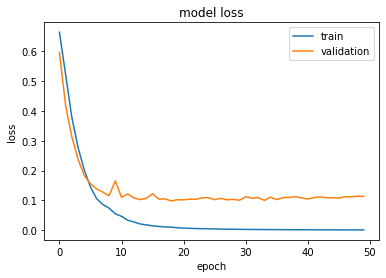

In [6]:
# TODO: Use model.fit to train the CNN model, with the number of epochs, verbose type.
history = model.fit()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Similarly, we can plot the accuracy of our neural network on the binary classification task. The metric used in this example is the _binary accuracy_, which calculates the proportion of predictions that match labels or response variables. Other metrics may be used in different tasks -- for example, the _mean squared error_ is typically used to measure the accuracy for continuous response variables (e.g. polygenic risk scores, total serum cholesterol level, height, weight and systolic blood pressure).

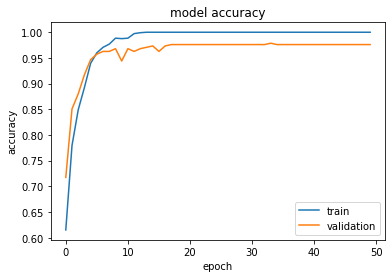

In [7]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## 3. Evaluate

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-12.png?raw=true)

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. 

With the model trained, we can use it to make predictions. The predict function call generates the output predictions given a set of input samples.

In [1]:
from sklearn.metrics import confusion_matrix
import itertools

# TODO: Use model.predict to train the CNN model, with the number of epochs, verbose type.
predicted_labels = model.predict()


NameError: name 'model' is not defined

Here, we evaluate the model on the test set and plot the results as a confusion matrix. Nearly every test sequence should be correctly classified.


Confusion matrix:
 [[248  11]
 [  0 241]]


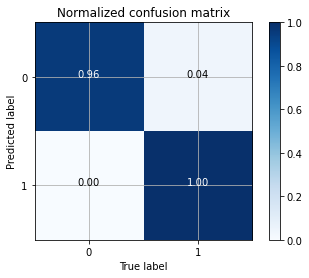

In [11]:

cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))

print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

## 4. Interpret

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-31.png?raw=true)

Your results so far should allow you to conclude that the neural network is quite effective in learning to distinguish sequences that bind the protein from sequences that do not. But can we understand _why_ the neural network classifies a training point in the way that it does? To do so, we can compute a simple _saliency map_, which is the gradient of the model's prediction with respect to each individual nucleotide. 

In other words, the saliency maps shows how the output response value changes with respect to a small changes in input nucleotide sequence. All the positive values in the gradients tell us that a small change to that nucleotide will change the output value. Hence, visualizing these gradients for a given input sequence, should provide some clues about what nucleotides form the binding motive that we are trying to identify.

In [12]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

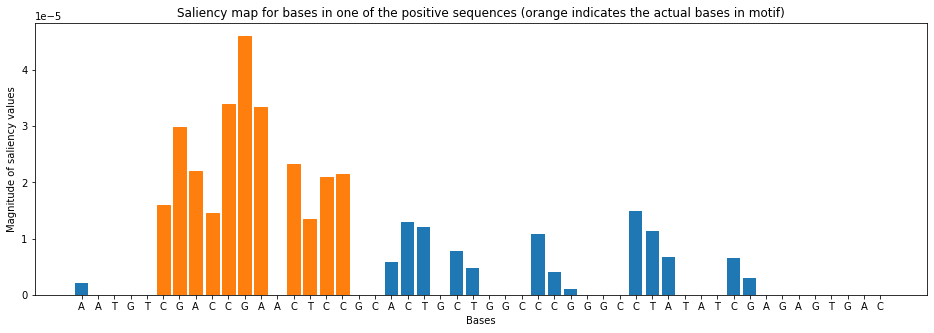

In [13]:
sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (orange indicates the actual bases in motif)');

The results above should show high saliency values for the bases _CGACCGAACTCC_ appearing in the DNA sequence. If you recall from the top of the document, this is exactly the motif that we embedded in the positive sequences! The raw saliency values may be non-zero for other bases as well -- the gradient-based saliency map method is not perfect, and there other more complex interpretation methods that are used in practice to obtain better results.  

Furthermore, we may explore other architectures for our neural network to see if we can improve performance on the validation dataset. For example, we could choose different _hyper-parameters_, which are variables that define the network structure (e.g. the number of dense or convolutional layers, the dimensionality of each layer, etc.) and variables that determine how the network is trained (e.g. the number of epochs, the learning rate, etc.). Testing different hyper-parameter values or performing a hyper-parameter search grid are good practices that may help the deep learning procedure to obtain a clearer signal for classifying sequences and identifying the binding motif.